## Background and Introduction  
This is intended to be an exploratory study to figure out how to try all of of the coffee places in Chicago. I've leveraged data solely from the the Chicago Open Data portal. Only part of my implementation is below. Most of it is in the library.py file, also in this repo. 

## Process and Results

In [1]:
%matplotlib inline 
from library import *

One of the first things I did was to bring in the neighborhood file, and marvel at a miniature representation of my city.

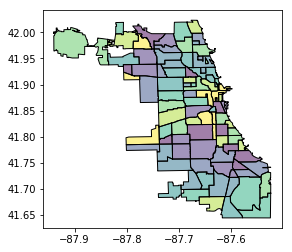

In [2]:
neighborhoods = loadNeighborhoods()

As with any data project, there's cleaning - lots of it. I processed the business liscence data from the Chicago Open Data, only kept lines that had 'coffee' in their business or legal name ('cafe' gets rather ambiguous, so it's disregarded). All capitalization, punctuation, and organization type references (corp, corporation, inc, llc, etc.) were removed to make this easier.

I stored this as a static dataset, then worked on it further below, combining nearest train stops then separating Starbucks locations from non-Starbucks locations. Note that already we can quickly get the percentage of non-Starbucks locations. 

I wanted to take ease of access by train into consideration because no one wants to be stuck on the bus all weekend. For that I grabbed, the CTA L stop dataset, also courtesy of the Chicago Open Data Portal, and transformed it like the Business Liscense data. 

This combined data set was then spatially joined with the previously loaded neighborhood data so that we have store information, nearest train stop to store, and neighborhood to store. The point data (store and train location data) are most expensive to process, so all of that is done ahead (CoffeePoint below). The spatial join to the neighborhood is left because its relatively inexpensive on my chromebook and keeping separating the datasets into points and polygons helps with debugging. 

In [3]:
CoffeePoint = loadCoffeePoint()
NameID = filterNameIDs(CoffeePoint)
coffeePoly,SbucksPoly,notSbucksPoly = createCoffeePolys(CoffeePoint,neighborhoods)

52.45% of locations were non-Starbucks


Now that there is a master dataset to work use, we can create some aggregations by neighborborhood and begin to create aggregate columns. We can expect a few outcomes of the ratio:  
> a) invalid (1/0,0/0) --> there are only 'Indie' locations  
> b) 0 --> there are only Starbucks locations  
> c) less than 1  --> there are more Starbucks than Indie locations  
> d) equals 1 --> Indie and Starbucks locations are in equal supply  
> e) more than 1  --> there are less Starbucks than Indie locations  
> f) nan  --> there are no locations  

**Reminder: only places with 'coffee' in their name made it this far in the process

In [4]:
joinedNeighData = transJoinData(SbucksPoly,notSbucksPoly,neighborhoods)
joinedNeighData.sample(5)

,geometry,neighborhood,SBcount,nSBcount,totalNeighLocs,pctNSB,pctSB,ratioNSBtoSB,ratioCategory,ratioCategoryCd
97,POLYGON ((-87.63144510787805 41.90390085847407...,River North,7.0,5.0,12.0,0.416667,0.583333,0.714286,SBDom,3
20,POLYGON ((-87.73146013483256 41.93173397304093...,Hermosa,0.0,0.0,0.0,NaN,NaN,NaN,None,0
50,"POLYGON ((-87.6421520465059 41.68508212044721,...",Morgan Park,0.0,0.0,0.0,NaN,NaN,NaN,None,0
23,POLYGON ((-87.64833293023899 41.87536702787534...,"Little Italy, UIC",0.0,3.0,3.0,1.000000,0.000000,inf,Ind,1
11,"POLYGON ((-87.5456769631521 41.72282057819383,...",Calumet Heights,0.0,1.0,1.0,1.000000,0.000000,inf,Ind,1


In [5]:
filtNeighRatios(transJoinData(SbucksPoly,notSbucksPoly,neighborhoods))

,neighborhood,SBcount,nSBcount,totalNeighLocs,pctNSB,pctSB,ratioNSBtoSB,ratioCategory,ratioCategoryCd
22,Logan Square,1.0,5.0,6.0,0.833333,0.166667,5.0,IndDom,5
56,Edgewater,1.0,5.0,6.0,0.833333,0.166667,5.0,IndDom,5
57,Lake View,5.0,10.0,15.0,0.666667,0.333333,2.0,IndDom,5
71,West Loop,10.0,8.0,18.0,0.444444,0.555556,0.8,SBDom,3
75,Andersonville,1.0,1.0,2.0,0.500000,0.500000,1.0,Eq,4
88,Wicker Park,1.0,4.0,5.0,0.800000,0.200000,4.0,IndDom,5


Given my own personal preferences, I'm most concerned with the 3's, 4's, and 5's, or neighborhoods that are dominant in one category or equal in ratio for them, seen below.

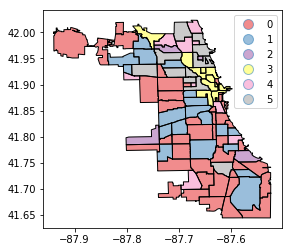

In [6]:
joinedNeighData.plot('ratioCategoryCd',categorical=True,legend=True,)

At the moment this isn't terribly surprising, especially if you're familiar with the some demographic stereotypes of the city. I, for example, live in Edgewater, one of the 5/grey spots. Logan Square, another one of my favorite places is grey. The yellow, where Starbuucks dominates, are places with pretty high real estate value- Lakeview, Lincoln Park, and the Loop.  
  
Here are some of the neighborhoods I was interested in:

In [7]:
neighView = filtNeighRatios(joinedNeighData)
neighView

,neighborhood,SBcount,nSBcount,totalNeighLocs,pctNSB,pctSB,ratioNSBtoSB,ratioCategory,ratioCategoryCd
22,Logan Square,1.0,5.0,6.0,0.833333,0.166667,5.0,IndDom,5
56,Edgewater,1.0,5.0,6.0,0.833333,0.166667,5.0,IndDom,5
57,Lake View,5.0,10.0,15.0,0.666667,0.333333,2.0,IndDom,5
71,West Loop,10.0,8.0,18.0,0.444444,0.555556,0.8,SBDom,3
75,Andersonville,1.0,1.0,2.0,0.500000,0.500000,1.0,Eq,4
88,Wicker Park,1.0,4.0,5.0,0.800000,0.200000,4.0,IndDom,5


Digging in further into my home neighborhood we get to the following:

In [8]:
eh20 = coffeePoly[coffeePoly['pri_neigh'].isin(['Edgewater'])]
favesFilt = eh20[['pri_neigh','LEGAL NAME','DOING BUSINESS AS NAME','distFromHome','distFromWork','ID','nearestBusinessID']]
favesFilt.reset_index(drop=True,inplace=True)
favesFilt.merge(NameID,how='left')

,pri_neigh,LEGAL NAME,DOING BUSINESS AS NAME,distFromHome,distFromWork,ID,nearestBusinessID,nearestBusinessName
0,Edgewater,the coffee studio,the coffee studio,0.010401,0.103350,1799696-20130816,1943453-20150816,metropolis coffee company
1,Edgewater,ellipsis coffeehouse,ellipsis coffeehouse llc,0.010683,0.115482,2240723-20130314,2283957-20131209,starbucks
2,Edgewater,starbucks,stabucks coffee #19283,0.009945,0.114936,2283957-20131209,2137785-20140216,tammie mann
3,Edgewater,mk companies,coffee chicago,0.010036,0.095220,2102649-20130716,1043368-20150416,starbucks
4,Edgewater,tammie mann,the coffee shop,0.010095,0.115045,2137785-20140216,2283957-20131209,starbucks
5,Edgewater,starbucks,starbucks coffee #2445,0.004691,0.100522,1043368-20150416,2102649-20130716,mk companies
6,Edgewater,metropolis coffee company,metropolis coffee company,0.006856,0.111112,1379788-20130816,2137785-20140216,tammie mann


In terms of practical use I wanted to see if I could craft a data-based starategy for checking out coffee places. For that, it seems reasonable to look at:  
a) distance from my home, for weekend exploration and  
b) distance from my office, for weekdays  
You can obviously see some of the limitations of eliminating anything without 'coffee' in its name, especially in the Distance from work table. More chains are represented and names repeated. The interesting thing about the first is that I frequent many of them already. 

In [9]:
notSbucksPoly.sort_values('distFromHome').head(10)[['pri_neigh','distFromHome','DOING BUSINESS AS NAME','STATION_NAME']]

,pri_neigh,distFromHome,DOING BUSINESS AS NAME,STATION_NAME
56,Edgewater,0.006856,metropolis coffee company,Granville
56,Edgewater,0.010036,coffee chicago,Berwyn
56,Edgewater,0.010095,the coffee shop,Loyola
56,Edgewater,0.010401,the coffee studio,Bryn Mawr
75,Andersonville,0.010422,metropolis coffee company,Bryn Mawr
56,Edgewater,0.010683,ellipsis coffeehouse llc,Loyola
33,Uptown,0.015245,new chinatown bakery & coffee shop,Argyle
25,Rogers Park,0.017501,royal coffee,Loyola
33,Uptown,0.023346,everybody's coffee,Wilson
33,Uptown,0.031590,dollop coffee and tea,Sheridan


In [10]:
notSbucksPoly.sort_values('distFromWork').head(10)[['pri_neigh','distFromWork','DOING BUSINESS AS NAME','STATION_NAME']]

,pri_neigh,distFromWork,DOING BUSINESS AS NAME,STATION_NAME
71,West Loop,0.002753,beavers coffee & donuts,Clinton
71,West Loop,0.007208,"ace coffee bar, inc.",Morgan
71,West Loop,0.007691,peet's coffee & tea,Clinton
97,River North,0.008705,peet's coffee & tea,Chicago
53,Loop,0.009013,caribou coffee company,Quincy/Wells
53,Loop,0.009142,xando coffee & bar / cosi sandwich bar,Washington/Wells
97,River North,0.009738,"intelligentsia coffee & tea, inc.",Merchandise Mart
97,River North,0.010154,robust coffee lounge llc,Chicago
97,River North,0.011041,bow truss coffee,Merchandise Mart
97,River North,0.011313,asado coffee roasters,Chicago


## Conclusion  
At present this study does not provide much guidance for exploring coffee places near my office. One of my favorite places in the city, Sawada, for example is not represented here. On the other hand, it supports the intuition that I live in a nice area, at least in terms of diverse coffee options.  

Next up I'll see if something is similar is applicable to other cities in the US. 